In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Load data
# data = pd.read_csv('/content/preprocessed_data.csv')
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# # Define input sequence length (number of past observations to consider)
# input_seq_length = 10  # Example: Use the past 10 observations

# # Create input sequences and target values
# X = []
# y = []

# for i in range(len(data) - input_seq_length):
#     X.append(data[['Throughput', 'LossRate', 'Latency', 'SendingRate']].iloc[i:i+input_seq_length].values)
#     y.append(data[['Throughput', 'LossRate', 'Latency', 'SendingRate']].iloc[i+input_seq_length].values)

# X = np.array(X)
# y = np.array(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Now X_train, X_test are input sequences, and y_train, y_test are target values


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


['/content/ client1 _bbr_full.csv',
           '/content/client1_cubic_full.csv',
           '/content/client1_pcc.csv',
           '/content/client2_bbr_switch_cubic.csv',
           '/content/client2_pcc.csv',
           '/content/client2_pcc_switch_bbr.csv']

# Load the dataset into a pandas DataFrame
# Assuming your data is stored in a CSV file named 'network_data.csv'
df = pd.read_csv('/content/preprocessed_data.csv')

# Extract relevant columns
features = ["Throughput", "LossRate", "Latency", "SendingRate"]
X = df[features]

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Add timestamps to the normalized feature vectors
timestamps = pd.to_datetime(df["Timestamp"])
state_representation = pd.concat([pd.DataFrame(timestamps), pd.DataFrame(X_normalized)], axis=1)
state_representation.columns = ["Timestamp"] + features
print(state_representation)


                        Timestamp  Throughput  LossRate   Latency  SendingRate
0   1970-01-01 00:00:01.717048758    0.760182  0.016432  0.005656     0.442732
1   1970-01-01 00:00:01.717048759    0.884752  0.001493  0.005097     0.462510
2   1970-01-01 00:00:01.717048760    0.689559  0.000856  0.005669     0.453094
3   1970-01-01 00:00:01.717048761    0.530437  0.000644  0.009459     0.540156
4   1970-01-01 00:00:01.717048762    0.338825  0.000546  0.008435     0.523768
..                            ...         ...       ...       ...          ...
629 1970-01-01 00:00:01.717054707    0.460341  0.000034  0.005437     0.809757
630 1970-01-01 00:00:01.717054708    0.475818  0.000033  0.005536     0.826026
631 1970-01-01 00:00:01.717054709    0.452155  0.000033  0.005054     0.797003
632 1970-01-01 00:00:01.717054710    0.477098  0.000032  0.005383     0.780425
633 1970-01-01 00:00:01.717054711    0.460341  0.000031  0.005021     0.832630

[634 rows x 5 columns]


In [ ]:
import pandas as pd
import os

# List of filenames
csv_files = [
    '/content/client1_bbr_full.csv',
    '/content/client1_cubic_full.csv',
    '/content/client1_pcc.csv',
    '/content/client2_bbr_switch_cubic.csv',
    '/content/client2_pcc.csv',
    '/content/client2_pcc_switch_bbr.csv'
]

# Function to extract CCA from the filename
def get_cca_from_filename(filename, switch_time=40):
    if 'switch' in filename:
        if 'bbr_switch_cubic' in filename:
            return 'BBR', 'CUBIC', switch_time
        elif 'pcc_switch_bbr' in filename:
            return 'PCC', 'BBR', switch_time
    elif 'bbr' in filename:
        return 'BBR', None, None
    elif 'cubic' in filename:
        return 'CUBIC', None, None
    elif 'pcc' in filename:
        return 'PCC', None, None
    else:
        return 'UNKNOWN', None, None

# Initialize an empty list to hold DataFrames
dataframes = []

# Loop through the list of CSV files and read each one into a DataFrame
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        if 'Timestamp' not in df.columns:
            print(f"Warning: 'Timestamp' column not found in {file}. Skipping this file.")
            continue
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Ensure Timestamp is in datetime format
        df['time'] = (df['Timestamp'] - df['Timestamp'].min()).dt.total_seconds()  # Create a 'time' column in seconds
        cca1, cca2, switch_time = get_cca_from_filename(file)
        if cca2 is None:
            df['CCA'] = cca1
        else:
            df['CCA'] = [cca1 if t <= switch_time else cca2 for t in df['time']]
        dataframes.append(df)
    else:
        print(f"File not found: {file}")

# Concatenate all DataFrames into a single DataFrame if dataframes list is not empty
if dataframes:
    combined_data = pd.concat(dataframes, ignore_index=True)
    # Save the combined DataFrame to a CSV file
    combined_data.to_csv('/content/combined_data.csv', index=False)
    print("Combined data saved to '/content/combined_data.csv'")
else:
    print("No valid files were found. Please check the file paths and content.")


File not found: /content/client1_bbr_full.csv
Combined data saved to '/content/combined_data.csv'


In [ ]:
# Check for missing values in the combined dataset
missing_values = combined_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
Timestamp       0
Throughput      0
LossRate        0
Latency        13
SendingRate     0
time            0
CCA             0
dtype: int64


In [ ]:
# Fill missing values for numerical columns with mean
for col in combined_data.select_dtypes(include=['float64', 'int64']).columns:
    combined_data[col].fillna(combined_data[col].mean(), inplace=True)

# Fill missing values for categorical columns with mode
for col in combined_data.select_dtypes(include=['object']).columns:
    combined_data[col].fillna(combined_data[col].mode()[0], inplace=True)

# Verify if all missing values are handled
missing_values_post = combined_data.isnull().sum()
print("Missing values after handling:")
print(missing_values_post)


Missing values after handling:
Timestamp      0
Throughput     0
LossRate       0
Latency        0
SendingRate    0
time           0
CCA            0
dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for standardization
numerical_cols = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Standardize numerical columns
scaler = StandardScaler()
combined_data[numerical_cols] = scaler.fit_transform(combined_data[numerical_cols])

# Display the first few rows after standardization
print(combined_data.head())


            Timestamp  Throughput   LossRate       Latency  SendingRate  \
0 2024-05-30 07:31:40   -2.063979  16.292751  8.473640e-17    -3.328244   
1 2024-05-30 07:31:41   -0.170823   0.580359  8.473640e-17    -0.282757   
2 2024-05-30 07:31:42    0.504422  -0.011853  8.473640e-17    -0.916587   
3 2024-05-30 07:31:43    1.590342  -0.047357  8.473640e-17    -0.755940   
4 2024-05-30 07:31:44    1.758314  -0.060487  8.473640e-17    -0.867777   

       time    CCA  
0 -1.712318  CUBIC  
1 -1.680774  CUBIC  
2 -1.649230  CUBIC  
3 -1.617685  CUBIC  
4 -1.586141  CUBIC  


In [ ]:
# Replace categorical values with numeric labels
combined_data['CCA'] = combined_data['CCA'].astype('category')
combined_data['CCA'] = combined_data['CCA'].cat.codes

# Impute missing values with the mean of each feature
combined_data.fillna(combined_data.mean(), inplace=True)

# Normalize features if needed (optional)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined_data[['Throughput', 'Latency', 'LossRate', 'SendingRate', 'CCA']] = scaler.fit_transform(combined_data[['Throughput', 'Latency', 'LossRate', 'SendingRate', 'CCA']])


In [ ]:
# Save preprocessed data to a CSV file
combined_data.to_csv('preprocessed_data.csv', index=False)


In [ ]:
# Split the data into training and testing sets
split_index = int(0.8 * len(combined_data))
train_data = combined_data.iloc[:split_index]
test_data = combined_data.iloc[split_index:]


In [ ]:
# import gym
# from gym import spaces
# import pandas as pd
# import numpy as np

# class CongestionControlEnv(gym.Env):
#     def __init__(self, data, thresholds):
#         super(CongestionControlEnv, self).__init__()
#         self.data = data
#         self.thresholds = thresholds
#         self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # Throughput, Latency, LossRate, SendingRate
#         self.action_space = spaces.Discrete(2)  # Binary action: 0 for no switch, 1 for switch
#         self.current_step = 0
#         self.state = None  # Initialize state as None

#         # Define weights and other parameters
#         self.ewma_state = np.zeros(4)
#         self.ewma_weight = 0.1
#         self.throughput_weight = 1.0
#         self.latency_weight = 0.5
#         self.loss_rate_weight = 0.5
#         self.sending_rate_weight = 1.0
#         self.training_phase = 'exploration'  # or 'exploitation'
#         self.exploration_reward = 0.1
#         self.switching_penalty = 0.5

#         # Initialize performance tracking for CCAs
#         self.ccas = ['CCA1', 'CCA2', 'CCA3']  # Example CCA names
#         self.current_cca = self.ccas[0]
#         self.performance_metrics = {cca: {'Throughput': 0, 'Latency': 0, 'LossRate': 0, 'SendingRate': 0} for cca in self.ccas}

#     def reset(self):
#         # Reset the environment
#         self.current_step = 0
#         self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
#         self.ewma_state = self.state  # Initialize EWMA state
#         return self.state if self.state is not None else np.zeros(4)  # Return zeros if state is None

#     def step(self, action):
#         # Take an action (0: no switch, 1: switch)
#         if action == 1:
#             # Switch the congestion control algorithm
#             self.switch_congestion_control_algorithm()

#         # Move to the next step
#         self.current_step += 1
#         done = self.current_step >= len(self.data)
#         if not done:
#             self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
#         else:
#             self.state = None

#         # Calculate reward
#         reward = self._calculate_reward(action)
#         return self.state, reward, done, {}

#     def _calculate_reward(self, action):
#         if self.state is None:  # Handle case where state is None
#             return 0

#         # Calculate disparities with smoothing (EWMA)
#         disparities = np.abs(self.state - self.ewma_state)
#         self.ewma_state = (1 - self.ewma_weight) * self.state + self.ewma_weight * self.ewma_state

#         # Normalize disparities to handle different scales of metrics
#         max_disparities = np.max(disparities, axis=0)
#         normalized_disparities = disparities / (max_disparities + 1e-6)  # Add a small value to avoid division by zero

#         # Reward based on weighted disparities
#         reward = 0
#         metric_weights = {
#             'Throughput': self.throughput_weight,
#             'Latency': self.latency_weight,
#             'LossRate': self.loss_rate_weight,
#             'SendingRate': self.sending_rate_weight
#         }
#         for metric, disparity in zip(metric_weights.keys(), normalized_disparities):
#             reward -= disparity * metric_weights[metric]  # Penalty for disparities

#         # Shaped reward for exploration (optional)
#         if self.training_phase == 'exploration':
#             reward += self.exploration_reward  # Encourage exploration

#         # Penalty for switching (optional)
#         if action == 1:  # Assuming action '1' corresponds to switching CCA
#             reward -= self.switching_penalty  # Discourage frequent switching

#         return reward

#     def switch_congestion_control_algorithm(self):
#         # Evaluate and switch to the best-performing CCA
#         best_cca = self.evaluate_best_cca()
#         if best_cca != self.current_cca:
#             self.current_cca = best_cca
#             print(f"Switched to congestion control algorithm: {self.current_cca}")

#     def evaluate_best_cca(self):
#         # Evaluate the performance of each CCA based on disparities
#         best_cca = self.current_cca
#         lowest_disparity = float('inf')

#         for cca in self.ccas:
#             metrics = self.performance_metrics[cca]
#             disparities = [
#                 metrics['Throughput'],
#                 metrics['Latency'],
#                 metrics['LossRate'],
#                 metrics['SendingRate']
#             ]
#             disparity = sum(disparities)  # You can use a more sophisticated method to calculate overall disparity
#             if disparity < lowest_disparity:
#                 lowest_disparity = disparity
#                 best_cca = cca

#         return best_cca




In [ ]:
import gym
from gym import spaces
import numpy as np



class CongestionControlEnv(gym.Env):
    def __init__(self, data, thresholds):
        super(CongestionControlEnv, self).__init__()
        self.data = data
        self.thresholds = thresholds
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # Throughput, Latency, LossRate, SendingRate
        self.action_space = spaces.Discrete(2)  # Binary action: 0 for no switch, 1 for switch
        self.current_step = 0
        self.state = None  # Initialize state as None
        self.current_cca = 0  # Index of the current congestion control algorithm (CCA)

        # Define weights and other parameters
        self.ewma_weight = 0.1
        self.metric_weights = {'Throughput': 1.0, 'Latency': 0.5, 'LossRate': 0.5, 'SendingRate': 1.0}
        self.switching_penalty = 0.5

    def reset(self):
        # Reset the environment
        self.current_step = 0
        self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
        return self.state if self.state is not None else np.zeros(4)  # Return zeros if state is None

    def step(self, action):
        # Take an action: switch to a different congestion control algorithm
        self.current_cca = action

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data)
        if not done:
            self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
        else:
            self.state = None

        # Calculate reward
        reward = self._calculate_reward()
        return self.state, reward, done, {}

    def _calculate_reward(self):
        if self.state is None:  # Handle case where state is None
            return 0

        # Calculate disparities with smoothing (EWMA)
        ewma_state = self._update_ewma_state(self.state)
        disparities = np.abs(self.state - ewma_state)

        # Reward based on weighted disparities
        reward = -np.dot(disparities, list(self.metric_weights.values()))

        # Penalty for switching
        if self.current_cca != 0:  # Penalize switching to a different CCA
            reward -= self.switching_penalty

        return reward

    def _update_ewma_state(self, state):
        if self.state is None:
            return state
        return (1 - self.ewma_weight) * state + self.ewma_weight * self.state


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, state_shape, action_space):
        self.state_shape = state_shape
        self.action_space = action_space
        self.model = self.build_model()
        self.replay_buffer = []
        self.buffer_size = 10000  # Maximum size of the replay buffer
        self.gamma = 0.95  # Discount factor for future rewards
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.loss_history = []
        self.reward_history = []

    def build_model(self):
        model = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=self.state_shape),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_space, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)  # Explore: choose random action
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        act_values = self.model.predict(state_tensor)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        if len(self.replay_buffer) >= self.buffer_size:
            self.replay_buffer.pop(0)  # Remove the oldest experience if buffer is full
        self.replay_buffer.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return  # Not enough samples to train
        minibatch = random.sample(self.replay_buffer, batch_size)
        total_loss = 0
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state_tensor = tf.convert_to_tensor(next_state, dtype=tf.float32)
                target = (reward + self.gamma * np.amax(self.model.predict(next_state_tensor)[0]))
            state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
            target_f = self.model.predict(state_tensor)
            target_f[0][action] = target
            history = self.model.fit(state_tensor, target_f, epochs=1, verbose=0)
            total_loss += history.history['loss'][0]
        self.loss_history.append(total_loss / batch_size)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        # Plot loss history
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Loss over Time')
        plt.legend()

        # Plot reward history
        plt.subplot(1, 2, 2)
        plt.plot(self.reward_history, label='Reward')
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Reward over Episodes')
        plt.legend()

        plt.show()


In [ ]:
import numpy as np

# Parameters
EPISODES = 1000
BATCH_SIZE = 32

# Initialize environment and agent
env = CongestionControlEnv(data=combined_data, thresholds=[0.1, 0.1, 0.1, 0.1])
state_shape = env.observation_space.shape
action_space = env.action_space.n
agent = DQNAgent(state_shape, action_space)

# Training loop
for episode in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_shape[0]])
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        if next_state is not None:
            next_state = np.reshape(next_state, [1, state_shape[0]])
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            state = next_state
        else:
            break
    agent.train(BATCH_SIZE)
    agent.reward_history.append(total_reward)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

# Plot the metrics
agent.plot_metrics()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Episode: 104, Total Reward: -85.5
1/1 [==============================] - 0s 37ms/step
Episode: 105, Total Reward: -76.0
1/1 [==============================] - 0s 27ms/step
Episode: 106, Total Reward: -73.5
1/1 [==============================] - 0s 38ms/step
Episode: 107, Total Reward: -76.5
1/1 [==============================] - 0s 24ms/step
Episode: 108, Total Reward: -83.0
1/1 [==============================] - 0s 34ms/step
Episode: 109, Total Reward: -75.5
1/1 [==============================] - 0s 26ms/step
Episode: 110, Total Reward: -78.5
1/1 [==============================] - 0s 35ms/step
Episode: 111, Total Reward: -82.0
1/1 [==============================] - 0s 23ms/step
Episode: 112, Total Reward: -77.0
1/1 [==============================] - 0s 30ms/step
Episode: 113, Total Reward: -80.0
1/1 [==============================] - 0s 37ms/step
Episode: 114, Total Reward: -75.5
1/1

In [25]:
# Initialize environment and agent
env = CongestionControlEnv(data=combined_data, thresholds=[0.1, 0.1, 0.1, 0.1])
state_shape = env.observation_space.shape
action_space = env.action_space.n
agent = DQNAgent(state_shape, action_space)

# Evaluation loop
test_total_reward = 0
test_state = env.reset()
test_state = np.reshape(test_state, [1, state_shape[0]])
test_done = False
while not test_done:
    test_action = agent.act(test_state)
    test_next_state, test_reward, test_done, _ = env.step(test_action)
    if test_next_state is not None:
        test_next_state = np.reshape(test_next_state, [1, state_shape[0]])
        test_total_reward += test_reward
        test_state = test_next_state
    else:
        break
print(f"Total Test Reward: {test_total_reward}")


Total Test Reward: -146.5


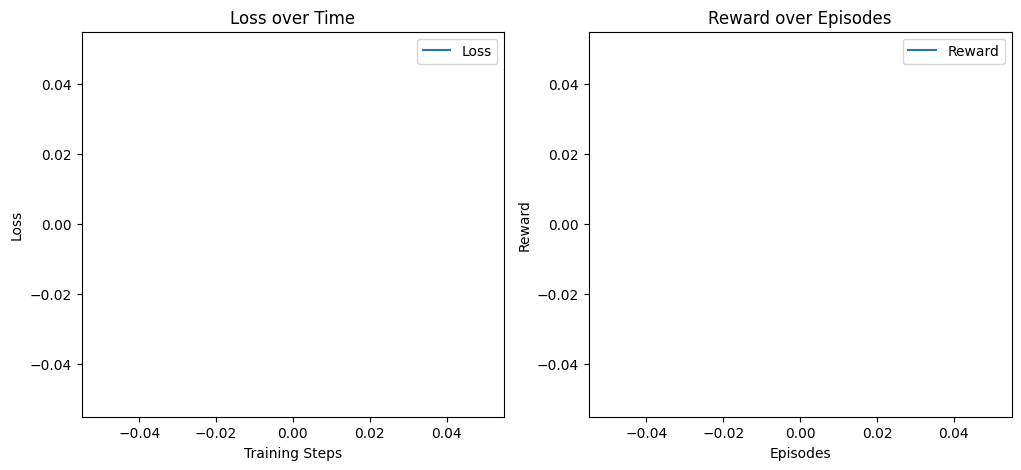

In [28]:
# Plot the metrics
agent.plot_metrics()

In [27]:
import matplotlib.pyplot as plt



 # Plot loss history
  plt.subplot(1, 2, 1)
    plt.plot(self.loss_history, label='Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss over Time')
    plt.legend()

    # Plot reward history
    plt.subplot(1, 2, 2)
    plt.plot(self.reward_history, label='Reward')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Reward over Episodes')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


IndentationError: unexpected indent (<ipython-input-27-8890a220614c>, line 6)